<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 10 &ndash; Meta-Learning</h2>

<b>Author:</b> Thomas Adler<br>
<b>Date:</b> 15-06-2020

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">Exercise 0 (Voluntarily, 0 Points)</h3>
In the theoretical part, we discussed a meta-learning method that casts RNNs as meta-learning systems (<i>learning to learn using gradient descent</i>). <b>What is the meta-parameter set $\psi$ and what is the learner's parameter set $\theta$ in this setting?</b> You do not need to define those sets formally. It is fine if you formulate the answer using words but make sure that you explain your answer sufficiently. 

<i>I guess that $\theta$ and $\psi$ are both the weights of the RNN: If I've undestood the concept correctly, everything we normally would present to the neural network 'manually' (trainset, testset, loss (we pass the prediction based on the last input and the correct corresponding label)), we now pass to the RNN at once as one datapoint. Therefore, the RNN learns to predict classes based on a trainset, a testset and the loss.</i>

<h3 style="color:rgb(0,120,170)">Exercise 1 (70 Points)</h3>
Consider the following slightly modified version of the demonstration notebook. Extend the network architecture by one additional convolutional layer with 50 input units and 50 output units and and a $5 \times 5$ kernel. This layer should use a stride of 1 and a padding of 2. Make sure to use BatchNorm analgogously to the other layers. Place the new layer between the second convolutional layer and the first fully connected layer. For this you will need to adapt the functions <code>__init__</code> and <code>forward</code> of the class <code>Net</code>. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from IPython.display import display
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
class NShotKWaySampler(torch.utils.data.Sampler):
    def __init__(self, dataset, k, n, q, epoch_length):
        super(NShotKWaySampler, self).__init__(dataset)
        self.dataset = dataset
        self.num_classes = len(dataset._characters)
        self.samples_per_class = len(dataset._flat_character_images) // self.num_classes
        self.epoch_length = epoch_length
        self.n, self.k, self.q = n, k, q
    
    def __iter__(self):
        def sample(k, spc):
            r = range(k * spc, (k+1) * spc) # index range of class k in dataset
            return np.random.choice(r, size=self.n+self.q, replace=False)
        
        for _ in range(self.epoch_length):
            classes = np.random.choice(self.num_classes, size=self.k, replace=False)
            samples = np.stack([sample(k, self.samples_per_class) for k in classes])
            support, query = samples[:,:self.n], samples[:,self.n:]
            yield np.concatenate([support.flatten(), query.flatten()])

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

k, n, q = 5, 1, 5

train_set = torchvision.datasets.Omniglot(root="./data", transform=transform, background=True)
train_sampler = NShotKWaySampler(train_set, k=k, n=n, q=q, epoch_length=100)
train_loader = torch.utils.data.DataLoader(train_set, batch_sampler=train_sampler)

test_set = torchvision.datasets.Omniglot(root="./data", transform=transform, background=False)
test_sampler = NShotKWaySampler(test_set, k=k, n=n, q=q, epoch_length=100)
test_loader = torch.utils.data.DataLoader(test_set, batch_sampler=test_sampler)

In [3]:
"""adapted from https://github.com/Crisescode/pytorch-mnist/blob/master/single_cpu/model.py"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.bn2 = nn.BatchNorm2d(50)
        
        # added layers
        self.conv3 = nn.Conv2d(50, 50, 5)
        self.bn3 = nn.BatchNorm2d(50)
        # ------------
        
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.bn4 = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 5)
    
    def forward(self, x, w):
        # we use the torch.nn.functional interface in our forward method
        x = F.conv2d(x, w['conv1.weight'], w['conv1.bias'], stride=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn1.weight'], bias=w['bn1.bias'], training=True)
        x = F.relu(x)
        x = F.conv2d(x, w['conv2.weight'], w['conv2.bias'], stride=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn2.weight'], bias=w['bn2.bias'], training=True)
        x = F.relu(x)
        
        # added layers
        x = F.conv2d(x, w['conv3.weight'], w['conv3.bias'], stride=1, padding=2)
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn3.weight'], bias=w['bn3.bias'], training=True)
        x = F.relu(x)
        # ------------
        
        x = x.view(-1, 4 * 4 * 50)
        x = F.linear(x, w['fc1.weight'], w['fc1.bias'])
        x = F.batch_norm(x, running_mean=None, running_var=None, weight=w['bn4.weight'], bias=w['bn4.bias'], training=True)
        x = F.relu(x)
        x = F.linear(x, w['fc2.weight'], w['fc2.bias'])
        return x

/home/liondungl/.programs/miniconda3/envs/HandsOnAI2Venv/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


training...
0.5344000002741813
0.6388000020384789
0.6928000023961067
0.7144000044465065
0.7404000031948089
0.7516000032424927
0.7668000000715256
0.7627999983727932
0.7915999984741211
0.8195999982953072
0.8076000010967255
0.777200001180172
0.8187999993562698
0.8239999982714653
0.8212000009417534
0.852799998819828
0.842399999499321
0.8399999988079071
0.8507999968528748
0.8583999988436699
0.8871999976038932
0.858799998164177
0.8927999967336655
0.8787999951839447
0.891999996304512
0.8803999957442283
0.8944000005722046
0.8887999975681304
0.9047999942302704
0.909599997997284
0.9303999966382981
0.91519999563694
0.9163999944925308
0.9207999941706657
0.9211999952793122
0.9227999955415725
0.9171999955177307
0.913999993801117
0.91519999563694
0.9191999977827072
0.9151999944448471
0.9087999975681305
0.907199998497963
0.9171999967098237
0.9275999927520752
0.92519999563694
0.9195999944210053
0.9195999950170517
0.9239999979734421
0.9335999971628189
0.9539999949932099
0.9419999974966049
0.947999997735

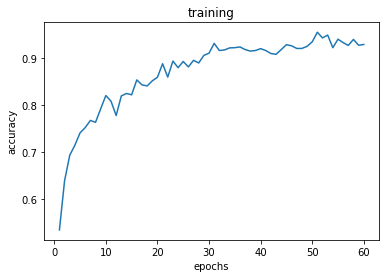

test accuracy = 0.8739999973773956 test loss = 0.35680362325161696
Took 4003.8717119999997 seconds


/home/liondungl/.programs/miniconda3/envs/HandsOnAI2Venv/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [4]:
import time

def alg(model, x, y, train, inner_steps=1, alpha=0.4):
    w = OrderedDict(model.named_parameters())
    
    for _ in range(inner_steps):
        logits = model(x, w)
        loss = F.cross_entropy(logits, y)
        grad = torch.autograd.grad(loss, w.values(), create_graph=train)
        w = OrderedDict((n, p - alpha * g) for ((n, p), g) in zip(w.items(), grad))
    
    return w

def epoch(model, loader, train):
    epoch_loss = []
    epoch_acc = []
    
    for img, _ in loader:
        s_img, q_img = img[:k*n], img[k*n:]
        w = alg(model, s_img, s_lbl, train=train)
        logits = model(q_img, w)
        loss = F.cross_entropy(logits, q_lbl)
        epoch_loss.append(loss.item())
        epoch_acc.append((logits.argmax(dim=1) == q_lbl).float().mean().item())
        
        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    return np.stack(epoch_loss).mean(), np.stack(epoch_acc).mean()

# in each episode we use label indices from 0..4 instead of the ones coming from Omniglot
lbl = torch.arange(k).view((-1, 1)).repeat(1, n+q)
s_lbl, q_lbl = lbl[:,:n].flatten(), lbl[:,n:].flatten()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start_time = time.clock()
print('training...')
train_accs, test_accs = [], []
num_epochs = 60

for _ in range(num_epochs):
    loss, acc = epoch(model, train_loader, train=True)
    print(acc)
    train_accs.append(acc)

loss, acc = epoch(model, test_loader, train=False)
test_accs.append(acc)

plt.title('training')
plt.plot(range(1, num_epochs + 1), train_accs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print('test accuracy =', acc, 'test loss =', loss)
print(f'Took {time.clock() - start_time} seconds')

<h3 style="color:rgb(0,120,170)">Exercise 2 (30 Points)</h3>
Implement first-order MAML. In the following lines of code you find another implementation of MAML but this time with a boolean flag named <code>second_order</code>. Adapt the function <code>alg</code> such that if <code>second_order==False</code> then first-order MAML is executed. Otherwise, second-order MAML should be executed. Test your code and compare the performance of fist-order and second-order MAML

training...


/home/liondungl/.programs/miniconda3/envs/HandsOnAI2Venv/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


0.29080000072717666
0.4072000014036894
0.43519999846816065
0.4532000017166138
0.4947999985516071
0.5532000022381545
0.5564000009000302
0.6092000006139279
0.5940000021457672
0.6380000036954879
0.657600003182888
0.6772000014781951
0.7068000042438507
0.6908000031113625
0.6956000006198884
0.7060000032186509
0.7340000021457672
0.7283999997377396
0.7168000039458274
0.7152000002562999
0.7432000017166138
0.7384000000357628
0.7560000011324882
0.7684000006318092
0.7544000014662743
0.7560000020265579
0.7696000021696091
0.7704000002145768
0.7667999994754792
0.7775999999046326
0.7699999994784593
0.7836000013351441
0.7808000028133393
0.7903999993205071
0.795200001001358
0.8039999994635582
0.7879999983310699
0.81200000166893
0.7999999994039535
0.8191999992728234
0.8107999968528747
0.7776000007987023
0.778400001525879
0.793999999165535
0.7971999993920327
0.8359999984502793
0.8191999986767768
0.8547999984025956
0.850399996638298
0.850399996638298
0.8243999987840652
0.8603999996185303
0.8571999979019165

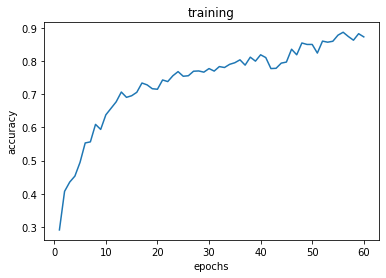

test accuracy = 0.792800001502037 test loss = 0.546753582879901
Took 2880.683193 seconds


/home/liondungl/.programs/miniconda3/envs/HandsOnAI2Venv/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [5]:
def alg(model, x, y, train, second_order, inner_steps=1, alpha=0.4):
    w = OrderedDict(model.named_parameters())
    
    for _ in range(inner_steps):
        logits = model(x, w)
        loss = F.cross_entropy(logits, y)
        # HINT: modify the following line
        grad = torch.autograd.grad(loss, w.values(), create_graph=second_order) # ∇θL(f(x, θ), y) 
        w = OrderedDict((n, p - alpha * g) for ((n, p), g) in zip(w.items(), grad)) # A(Dst, θ)
    
    return w

def epoch(model, loader, train, second_order):
    epoch_loss = []
    epoch_acc = []
    
    for img, _ in loader:
        s_img, q_img = img[:k*n], img[k*n:]
        w = alg(model, s_img, s_lbl, train=train, second_order=second_order)
        logits = model(q_img, w)
        loss = F.cross_entropy(logits, q_lbl)
        epoch_loss.append(loss.item())
        epoch_acc.append((logits.argmax(dim=1) == q_lbl).float().mean().item())
        
        if train:
            optimizer.zero_grad()
            loss.backward() # θ − β ∇θA(Dst, θ) ∇A(Dst,θ)L(f(x, A(Dst, θ)), y)
            optimizer.step() 
        
    return np.stack(epoch_loss).mean(), np.stack(epoch_acc).mean()

# in each episode we use label indices from 0..4 instead of the ones coming from Omniglot
lbl = torch.arange(k).view((-1, 1)).repeat(1, n+q)
s_lbl, q_lbl = lbl[:,:n].flatten(), lbl[:,n:].flatten()
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
start_time = time.clock()
print('training...')
train_accs, test_accs = [], []
num_epochs = 60

for _ in range(num_epochs):
    loss, acc = epoch(model, train_loader, train=True, second_order=False)
    print(acc)
    train_accs.append(acc)

loss, acc = epoch(model, test_loader, train=False, second_order=False)
test_accs.append(acc)

plt.title('training')
plt.plot(range(1, num_epochs + 1), train_accs)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print('test accuracy =', acc, 'test loss =', loss)
print(f'Took {time.clock() - start_time} seconds')

# Comparison
The first order MAML has a slightly lower test accuracy and a slightly higher test loss than the second-order MAML. Moreover, the training-curve of the second-order MAML is very steep at the beginning, whereas the first-oder MAML training curve has a more constant ascent.

Regarding the time it took to train the model, the first-order MAML does better than the second-oder MAML.

--> First-oder MAML is less accurate than second-oder MAML, but its training time is much better.